In [135]:
from IPython.display import clear_output
!pip install fancyimpute
!pip install statsmodels miceforest
!pip install h2o
clear_output()

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import h2o
from h2o.automl import H2OAutoML
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import models, Sequential, layers, Model, metrics


In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
TRAIN_PATH = '/content/drive/MyDrive/Spaceship-titanic/train.csv'
TEST_PATH = '/content/drive/MyDrive/Spaceship-titanic/test.csv'
TARGET_CLASS = 'Transported'

In [139]:
#functions

def missing_value(df):
      missing_values = df.isna().sum().to_frame()
      missing_values = missing_values.rename(columns= {0: 'missing_values'})
      missing_values['% of total'] = (missing_values['missing_values'] / df.shape[0]).round(2)*100
      return missing_values

In [193]:
df = pd.read_csv(TRAIN_PATH)

In [194]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [196]:
#missing column
missing = missing_value(df)
missing

missing_values  % of total
PassengerId                0         0.0
HomePlanet               201         2.0
CryoSleep                217         2.0
Cabin                    199         2.0
Destination              182         2.0
Age                      179         2.0
VIP                      203         2.0
RoomService              181         2.0
FoodCourt                183         2.0
ShoppingMall             208         2.0
Spa                      183         2.0
VRDeck                   188         2.0
Name                     200         2.0
Transported                0         0.0

In [197]:
fig = px.bar(x=missing.index, y='missing_values', data_frame=missing)
fig.update_layout(width=800, height=600)
fig.show()

In [198]:
#replace null values in the dataframe

for col in df.columns:
  if df[str(col)].dtypes == 'object':
    df[str(col)].fillna(df[str(col)].mode()[0], inplace=True)
  elif df[str(col)].dtypes == 'float64':
    df[str(col)].fillna(df[str(col)].mean().round(0), inplace=True)



In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(5)
memory usage: 772.6+ KB


In [213]:
#create categorical column for age

map_age = {'Children': range(0,13),
           'Teenagers': range(13,18),
           'young Adult': range(18,30),
           'Middle Age': range(30,50),
           'Elderly' : range(50,100)
           }

df['Age_category'] = df['Age'].apply(lambda x:next((k for k, v in map_age.items() if x in v), 'unknown'))

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [214]:
df['Cabin'].value_counts

<bound method IndexOpsMixin.value_counts of 0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object>

In [215]:
df[['Deck', 'Cabin_num', 'side']] = df['Cabin'].str.split('/', expand=True)

In [216]:
df.head()

PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  \
0     0001_01     Europa          0  B/0/P  TRAPPIST-1e  39.0    0   
1     0002_01      Earth          0  F/0/S  TRAPPIST-1e  24.0    0   
2     0003_01     Europa          0  A/0/S  TRAPPIST-1e  58.0    1   
3     0003_02     Europa          0  A/0/S  TRAPPIST-1e  33.0    0   
4     0004_01      Earth          0  F/1/S  TRAPPIST-1e  16.0    0   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported Deck Cabin_num side Age_category  
0            0    B         0    P   Middle Age  
1            1    F         0    S  young Adult  
2            0    A         0    S      Elderly  
3            0    A         0    S   Middle Age  
4            1    F         1    S    Teenagers

In [217]:
df['Cabin_num'] = df['Cabin_num'].astype(int)

In [218]:
df.corr()

<ipython-input-218-2f6f6606aa2c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



CryoSleep       Age       VIP  RoomService  FoodCourt  \
CryoSleep      1.000000 -0.070680 -0.078281    -0.243985  -0.205683   
Age           -0.070680  1.000000  0.091545     0.067589   0.127931   
VIP           -0.078281  0.091545  1.000000     0.056595   0.126006   
RoomService   -0.243985  0.067589  0.056595     1.000000  -0.015521   
FoodCourt     -0.205683  0.127931  0.126006    -0.015521   1.000000   
ShoppingMall  -0.206363  0.032625  0.018484     0.052963  -0.013935   
Spa           -0.198392  0.121001  0.060573     0.009925   0.220587   
VRDeck        -0.193107  0.099204  0.123092    -0.019207   0.224275   
Transported    0.460132 -0.074249 -0.037261    -0.242049   0.046074   
Cabin_num     -0.035665 -0.129335 -0.096637    -0.007401  -0.179867   

              ShoppingMall       Spa    VRDeck  Transported  Cabin_num  
CryoSleep        -0.206363 -0.198392 -0.193107     0.460132  -0.035665  
Age               0.032625  0.121001  0.099204    -0.074249  -0.129335  
VIP               0.018484  0.060573  0.123092    -0.037261  -0.096637  
RoomService       0.052963  0.009925 -0.019207    -0.242049  -0.007401  
FoodCourt        -0.013935  0.220587  0.224275     0.046074  -0.179867  
ShoppingMall      1.000000  0.013677 -0.007189     0.010020   0.001286  
Spa               0.013677  1.000000  0.147956    -0.218791  -0.125339  
VRDeck           -0.007189  0.147956  1.000000    -0.204825  -0.136704  
Transported       0.010020 -0.218791 -0.204825     1.000000  -0.044556  
Cabin_num         0.001286 -0.125339 -0.136704    -0.044556   1.000000

In [228]:
#replace bool with 1, 0 
bool_column = df.select_dtypes(include='bool').columns

df[bool_column] = df[bool_column].astype(bool)

In [220]:
drop_data = []
for col in df.columns:
  if len(df[str(col)].unique())/len(df[str(col)]) > 0.2:
    drop_data.append(col)

In [229]:
df.head()

PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  \
0     0001_01     Europa          0  B/0/P  TRAPPIST-1e  39.0    0   
1     0002_01      Earth          0  F/0/S  TRAPPIST-1e  24.0    0   
2     0003_01     Europa          0  A/0/S  TRAPPIST-1e  58.0    1   
3     0003_02     Europa          0  A/0/S  TRAPPIST-1e  33.0    0   
4     0004_01      Earth          0  F/1/S  TRAPPIST-1e  16.0    0   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported Deck  Cabin_num side Age_category  
0            0    B          0    P   Middle Age  
1            1    F          0    S  young Adult  
2            0    A          0    S      Elderly  
3            0    A          0    S   Middle Age  
4            1    F          1    S    Teenagers

In [221]:
drop_data.append('Age')

In [231]:
df_clean = df.drop(columns=['Name', 'Cabin', 'Age', 'PassengerId',], axis=1)
df_clean.head()

HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0     Europa          0  TRAPPIST-1e    0          0.0        0.0   
1      Earth          0  TRAPPIST-1e    0        109.0        9.0   
2     Europa          0  TRAPPIST-1e    1         43.0     3576.0   
3     Europa          0  TRAPPIST-1e    0          0.0     1283.0   
4      Earth          0  TRAPPIST-1e    0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported Deck  Cabin_num side Age_category  
0           0.0     0.0     0.0            0    B          0    P   Middle Age  
1          25.0   549.0    44.0            1    F          0    S  young Adult  
2           0.0  6715.0    49.0            0    A          0    S      Elderly  
3         371.0  3329.0   193.0            0    A          0    S   Middle Age  
4         151.0   565.0     2.0            1    F          1    S    Teenagers

In [223]:
df['Age_category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Age_category
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB


In [232]:
object_column = df_clean.select_dtypes(include='object').columns.to_list()

In [233]:
df_clean1 = pd.get_dummies(df_clean, columns=object_column)

In [234]:
df_clean1.corr()['Transported']

CryoSleep                    0.460132
VIP                         -0.037261
RoomService                 -0.242049
FoodCourt                    0.046074
ShoppingMall                 0.010020
Spa                         -0.218791
VRDeck                      -0.204825
Transported                  1.000000
Cabin_num                   -0.044556
HomePlanet_Earth            -0.168845
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.096319
Deck_A                      -0.002623
Deck_B                       0.144733
Deck_C                       0.108193
Deck_D                      -0.034046
Deck_E                      -0.097965
Deck_F                      -0.087753
Deck_G                       0.015822
Deck_T                      -0.014568
side_P                      -0.101397
side_S                       0.101397
Age_category_Children        0.125399
Age_category

In [161]:
df_clean1.isna().any()

CryoSleep                    False
VIP                          False
RoomService                  False
FoodCourt                    False
ShoppingMall                 False
Spa                          False
VRDeck                       False
Transported                  False
HomePlanet_Earth             False
HomePlanet_Europa            False
HomePlanet_Mars              False
Destination_55 Cancri e      False
Destination_PSO J318.5-22    False
Destination_TRAPPIST-1e      False
Age_category_Children        False
Age_category_Elderly         False
Age_category_Middle Age      False
Age_category_Teenagers       False
Age_category_young Adult     False
Deck_A                       False
Deck_B                       False
Deck_C                       False
Deck_D                       False
Deck_E                       False
Deck_F                       False
Deck_G                       False
Deck_T                       False
side_P                       False
side_S              

# Mice 

In [235]:
mice_imputer = IterativeImputer()
df_column = df_clean1.columns
X_imputed = mice_imputer.fit_transform(df_clean1)

In [236]:
X_imputed

array([[  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   0., 109., ...,   0.,   0.,   1.],
       [  0.,   1.,  43., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   1.],
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   0., 126., ...,   1.,   0.,   0.]])

In [237]:
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = df_column
df_imputed.head()
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   float64
 1   VIP                        8693 non-null   float64
 2   RoomService                8693 non-null   float64
 3   FoodCourt                  8693 non-null   float64
 4   ShoppingMall               8693 non-null   float64
 5   Spa                        8693 non-null   float64
 6   VRDeck                     8693 non-null   float64
 7   Transported                8693 non-null   float64
 8   Cabin_num                  8693 non-null   float64
 9   HomePlanet_Earth           8693 non-null   float64
 10  HomePlanet_Europa          8693 non-null   float64
 11  HomePlanet_Mars            8693 non-null   float64
 12  Destination_55 Cancri e    8693 non-null   float64
 13  Destination_PSO J318.5-22  8693 non-null   float

In [238]:
df_clean1.corr()['Transported']

CryoSleep                    0.460132
VIP                         -0.037261
RoomService                 -0.242049
FoodCourt                    0.046074
ShoppingMall                 0.010020
Spa                         -0.218791
VRDeck                      -0.204825
Transported                  1.000000
Cabin_num                   -0.044556
HomePlanet_Earth            -0.168845
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.096319
Deck_A                      -0.002623
Deck_B                       0.144733
Deck_C                       0.108193
Deck_D                      -0.034046
Deck_E                      -0.097965
Deck_F                      -0.087753
Deck_G                       0.015822
Deck_T                      -0.014568
side_P                      -0.101397
side_S                       0.101397
Age_category_Children        0.125399
Age_category

In [166]:
for col in df_clean1.columns:
  fig = px.bar(df_clean1, x=str(col), color='Transported')
  fig.update_layout(width=800, height=600)
  fig.show()

# KNN

In [167]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(df_imputed.drop('Transported', axis=1))
y = kmeans.labels_


In [168]:
pd.Series(y)

0       1
1       1
2       0
3       1
4       1
       ..
8688    0
8689    1
8690    1
8691    1
8692    0
Length: 8693, dtype: int32

In [169]:
df_imputed['knn_class'] = pd.Series(y)

In [170]:
df_imputed

CryoSleep  VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0           0.0  0.0          0.0        0.0           0.0     0.0     0.0   
1           0.0  0.0        109.0        9.0          25.0   549.0    44.0   
2           0.0  1.0         43.0     3576.0           0.0  6715.0    49.0   
3           0.0  0.0          0.0     1283.0         371.0  3329.0   193.0   
4           0.0  0.0        303.0       70.0         151.0   565.0     2.0   
...         ...  ...          ...        ...           ...     ...     ...   
8688        0.0  1.0          0.0     6819.0           0.0  1643.0    74.0   
8689        1.0  0.0          0.0        0.0           0.0     0.0     0.0   
8690        0.0  0.0          0.0        0.0        1872.0     1.0     0.0   
8691        0.0  0.0          0.0     1049.0           0.0   353.0  3235.0   
8692        0.0  0.0        126.0     4688.0           0.0     0.0    12.0   

      Transported  HomePlanet_Earth  HomePlanet_Europa  ...  Deck_B  Deck_C  \
0             0.0               0.0                1.0  ...     1.0     0.0   
1             1.0               1.0                0.0  ...     0.0     0.0   
2             0.0               0.0                1.0  ...     0.0     0.0   
3             0.0               0.0                1.0  ...     0.0     0.0   
4             1.0               1.0                0.0  ...     0.0     0.0   
...           ...               ...                ...  ...     ...     ...   
8688          0.0               0.0                1.0  ...     0.0     0.0   
8689          0.0               1.0                0.0  ...     0.0     0.0   
8690          1.0               1.0                0.0  ...     0.0     0.0   
8691          0.0               0.0                1.0  ...     0.0     0.0   
8692          1.0               0.0                1.0  ...     0.0     0.0   

      Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  side_P  side_S  knn_class  
0        0.0     0.0     0.0     0.0     0.0     1.0     0.0          1  
1        0.0     0.0     1.0     0.0     0.0     0.0     1.0          1  
2        0.0     0.0     0.0     0.0     0.0     0.0     1.0          0  
3        0.0     0.0     0.0     0.0     0.0     0.0     1.0          1  
4        0.0     0.0     1.0     0.0     0.0     0.0     1.0          1  
...      ...     ...     ...     ...     ...     ...     ...        ...  
8688     0.0     0.0     0.0     0.0     0.0     1.0     0.0          0  
8689     0.0     0.0     0.0     1.0     0.0     0.0     1.0          1  
8690     0.0     0.0     0.0     1.0     0.0     0.0     1.0          1  
8691     0.0     1.0     0.0     0.0     0.0     0.0     1.0          1  
8692     0.0     1.0     0.0     0.0     0.0     0.0     1.0          0  

[8693 rows x 30 columns]

# Pca

In [239]:
#visualise dataset in 3d space with pca

X = df_imputed.drop('Transported', axis=1)
y = df_imputed['Transported']

n_components = 3
pca  = PCA(n_components=n_components)

x_pca = pca.fit_transform(X)
a = pca.explained_variance_ratio_
n = 1
for i in a:
  print(f'Explained variance of component {n} {i.round(2)*100}')
  n+=1


df_pca = pd.DataFrame(x_pca, columns=['comp_1', 'comp_2', 'comp_3'])
df_pca['Transported'] = y

df_pca


Explained variance of component 1 46.0
Explained variance of component 2 20.0
Explained variance of component 3 18.0


comp_1       comp_2       comp_3  Transported
0     -547.573174  -193.806889   -27.706764          0.0
1     -377.028541   170.632968   350.403940          1.0
2     4586.193339  2548.484179  4850.109760          0.0
3     1594.959455  1478.287671  2287.502194          0.0
4     -330.679889   129.135222   396.315521          1.0
...           ...          ...          ...          ...
8688  6165.770905 -1847.268778  1052.706191          0.0
8689  -650.742366  -255.098411   -24.167889          0.0
8690  -659.124225  -237.990989     4.093989          1.0
8691  1385.167370  1780.236077 -1960.779736          0.0
8692  3708.544486 -2073.585068   -87.513579          1.0

[8693 rows x 4 columns]

In [172]:
a = pca.explained_variance_ratio_
n = 1
for i in a:
  print(f'Explained variance of  component{n} {i.round(2)*100}')
  n+=1


Explained variance of  component1 47.0
Explained variance of  component2 21.0
Explained variance of  component3 18.0


In [173]:
fig = px.scatter_3d(df_pca, x='comp_1', y='comp_2', z='comp_3', color='Transported', title='visualisation of Dataset in 3d space')
fig.show()

In [174]:
df_imputed

CryoSleep  VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0           0.0  0.0          0.0        0.0           0.0     0.0     0.0   
1           0.0  0.0        109.0        9.0          25.0   549.0    44.0   
2           0.0  1.0         43.0     3576.0           0.0  6715.0    49.0   
3           0.0  0.0          0.0     1283.0         371.0  3329.0   193.0   
4           0.0  0.0        303.0       70.0         151.0   565.0     2.0   
...         ...  ...          ...        ...           ...     ...     ...   
8688        0.0  1.0          0.0     6819.0           0.0  1643.0    74.0   
8689        1.0  0.0          0.0        0.0           0.0     0.0     0.0   
8690        0.0  0.0          0.0        0.0        1872.0     1.0     0.0   
8691        0.0  0.0          0.0     1049.0           0.0   353.0  3235.0   
8692        0.0  0.0        126.0     4688.0           0.0     0.0    12.0   

      Transported  HomePlanet_Earth  HomePlanet_Europa  ...  Deck_B  Deck_C  \
0             0.0               0.0                1.0  ...     1.0     0.0   
1             1.0               1.0                0.0  ...     0.0     0.0   
2             0.0               0.0                1.0  ...     0.0     0.0   
3             0.0               0.0                1.0  ...     0.0     0.0   
4             1.0               1.0                0.0  ...     0.0     0.0   
...           ...               ...                ...  ...     ...     ...   
8688          0.0               0.0                1.0  ...     0.0     0.0   
8689          0.0               1.0                0.0  ...     0.0     0.0   
8690          1.0               1.0                0.0  ...     0.0     0.0   
8691          0.0               0.0                1.0  ...     0.0     0.0   
8692          1.0               0.0                1.0  ...     0.0     0.0   

      Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  side_P  side_S  knn_class  
0        0.0     0.0     0.0     0.0     0.0     1.0     0.0          1  
1        0.0     0.0     1.0     0.0     0.0     0.0     1.0          1  
2        0.0     0.0     0.0     0.0     0.0     0.0     1.0          0  
3        0.0     0.0     0.0     0.0     0.0     0.0     1.0          1  
4        0.0     0.0     1.0     0.0     0.0     0.0     1.0          1  
...      ...     ...     ...     ...     ...     ...     ...        ...  
8688     0.0     0.0     0.0     0.0     0.0     1.0     0.0          0  
8689     0.0     0.0     0.0     1.0     0.0     0.0     1.0          1  
8690     0.0     0.0     0.0     1.0     0.0     0.0     1.0          1  
8691     0.0     1.0     0.0     0.0     0.0     0.0     1.0          1  
8692     0.0     1.0     0.0     0.0     0.0     0.0     1.0          0  

[8693 rows x 30 columns]

In [263]:
df_imputed.columns.to_list()

['CryoSleep',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Cabin_num',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Age_category_Children',
 'Age_category_Elderly',
 'Age_category_Middle Age',
 'Age_category_Teenagers',
 'Age_category_young Adult',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'side_P',
 'side_S']

In [240]:
X = df_imputed.drop('Transported', axis=1)
y = df_imputed['Transported']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [267]:
a = x_train.columns.to_list()

In [246]:
def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        #layers.Normalization(name='normalisation'),
        layers.Dense(256, activation='linear', name='dense1'),
        #layers.Dropout(0.3, name='dropout'),
        layers.Dense(512, activation='sigmoid', name='dense2'),
        #layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    )
    return model


In [247]:
model = model()

In [248]:
EPOCHS = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [249]:
model.compile(optimizer=optimizer,
            loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [250]:
history = model.fit(
    x_train_scaled, y_train, 
    validation_data=(x_test_scaled, y_test), 
    epochs=EPOCHS,
    batch_size=256
    )

Epoch 1/500
24/24 [==============================] - 2s 32ms/step - loss: 0.6431 - accuracy: 0.6695 - precision: 0.6746 - recall: 0.6643 - val_loss: 0.5901 - val_accuracy: 0.7370 - val_precision: 0.7530 - val_recall: 0.7106
Epoch 2/500
24/24 [==============================] - 1s 23ms/step - loss: 0.5619 - accuracy: 0.7469 - precision: 0.7699 - recall: 0.7096 - val_loss: 0.5228 - val_accuracy: 0.7596 - val_precision: 0.7775 - val_recall: 0.7319
Epoch 3/500
24/24 [==============================] - 1s 27ms/step - loss: 0.5118 - accuracy: 0.7594 - precision: 0.7804 - recall: 0.7269 - val_loss: 0.4848 - val_accuracy: 0.7722 - val_precision: 0.7869 - val_recall: 0.7510
Epoch 4/500
24/24 [==============================] - 1s 23ms/step - loss: 0.4820 - accuracy: 0.7683 - precision: 0.7921 - recall: 0.7321 - val_loss: 0.4642 - val_accuracy: 0.7814 - val_precision: 0.8028 - val_recall: 0.7502
Epoch 5/500
24/24 [==============================] - 1s 26ms/step - loss: 0.4666 - accuracy: 0.7780 - pr

In [182]:
"""
test = pd.read_csv(TEST_PATH)


for col in test.columns:
  if test[str(col)].dtypes == 'object':
    test[str(col)].fillna(test[str(col)].mode()[0], inplace=True)
  elif test[str(col)].dtypes == 'float64':
    test[str(col)].fillna(test[str(col)].mean().round(0), inplace=True)


test['Age_category'] = test['Age'].apply(lambda x:next((k for k, v in map_age.items() if x in v), 'unknown'))
test[['Deck', 'Cabin_num', 'side']] = test['Cabin'].str.split('/', expand=True)
bool_column = test.select_dtypes(include='bool').columns

test[bool_column] = test[bool_column].replace([True, False],[1, 0])
test_clean = test.drop(columns=drop_data, axis=1)
test_clean1 = pd.get_dummies(test_clean, columns=object_column)

test_column = test_clean1.columns
X_imputed = mice_imputer.fit_transform(test_clean1)

test_imputed = pd.DataFrame(X_imputed)
test_imputed.columns = test_column

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(test_imputed)
y = kmeans.labels_
pd.Series(y)

test_imputed['knn_class'] = pd.Series(y)

test = scaler.transform(test_imputed)
"""

In [268]:
df = pd.read_csv(TEST_PATH)
for col in df.columns:
  if df[str(col)].dtypes == 'object':
    df[str(col)].fillna(df[str(col)].mode()[0], inplace=True)
  elif df[str(col)].dtypes == 'float64':
    df[str(col)].fillna(df[str(col)].mean().round(0), inplace=True)


df['Age_category'] = df['Age'].apply(lambda x:next((k for k, v in map_age.items() if x in v), 'unknown'))
df[['Deck', 'Cabin_num', 'side']] = df['Cabin'].str.split('/', expand=True)
df['Cabin_num'] = df['Cabin_num'].astype(int)
bool_column = df.select_dtypes(include='bool').columns

df[bool_column] = df[bool_column].astype(bool)
df_clean = df.drop(columns=['Name', 'Cabin', 'Age', 'PassengerId',], axis=1)
object_column = df_clean.select_dtypes(include='object').columns.to_list()
df_clean1 = pd.get_dummies(df_clean, columns=object_column)
df_column = df_clean1.columns
X_imputed = mice_imputer.fit_transform(df_clean1)
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = df_column


test = scaler.transform(df_imputed[a])

In [269]:
pred = model.predict(test)

134/134 [==============================] - 0s 2ms/step


In [270]:
pred

array([[0.5190313 ],
       [0.00402794],
       [0.9993567 ],
       ...,
       [0.9870826 ],
       [0.7457237 ],
       [0.6315891 ]], dtype=float32)

In [271]:
threshold = 0.5
binary_predictions = np.where(pred >= threshold, 1, 0)

In [272]:
binary_predictions
p = pd.DataFrame(binary_predictions, columns=['T'])

In [273]:
test = pd.read_csv(TEST_PATH)

In [274]:
test['Transported'] = p['T'].astype(bool)

In [275]:
submission = test[['PassengerId', 'Transported']]
submission.to_csv('submission.csv', index=False)


In [276]:
pd.read_csv('./submission.csv')

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01        False
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]

In [111]:
model.save('/content/drive/MyDrive/Spaceship-titanic/model.h5')

In [ ]:
fig = px.scatter_3d(df_pca, x='comp_1', y='comp_2', z='comp_3', color='knn_class', title='visualisation of Dataset in 3d space')
fig.show()

In [ ]:
X = df_pca.drop('Transported', axis=1)
y = df_pca['Transported']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        layers.Normalization(name='normalisation'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    )
    return model


In [ ]:
model = model()

In [ ]:
EPOCHS = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
            loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

In [ ]:
history = model.fit(
    x_train_scaled, y_train, 
    validation_data=(x_test_scaled, y_test), 
    epochs=EPOCHS,
    batch_size=256
    )

Epoch 1/50
24/24 [==============================] - 4s 92ms/step - loss: 0.6016 - accuracy: 0.6896 - precision: 0.6387 - val_loss: 0.5600 - val_accuracy: 0.7063 - val_precision: 0.6487
Epoch 2/50
24/24 [==============================] - 1s 53ms/step - loss: 0.5715 - accuracy: 0.7035 - precision: 0.6532 - val_loss: 0.5471 - val_accuracy: 0.7159 - val_precision: 0.6682
Epoch 3/50
24/24 [==============================] - 2s 70ms/step - loss: 0.5595 - accuracy: 0.7141 - precision: 0.6704 - val_loss: 0.5499 - val_accuracy: 0.7086 - val_precision: 0.6581
Epoch 4/50
24/24 [==============================] - 2s 75ms/step - loss: 0.5495 - accuracy: 0.7185 - precision: 0.6779 - val_loss: 0.5330 - val_accuracy: 0.7247 - val_precision: 0.6858
Epoch 5/50
24/24 [==============================] - 1s 55ms/step - loss: 0.5438 - accuracy: 0.7257 - precision: 0.6906 - val_loss: 0.5281 - val_accuracy: 0.7347 - val_precision: 0.7066
Epoch 6/50
24/24 [==============================] - 1s 42ms/step - loss: 0.

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         1 min 23 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.4
H2O_cluster_version_age:    1 month and 12 days
H2O_cluster_name:           H2O_from_python_unknownUser_gopgtk
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [6]:
df_h2o = h2o.import_file(TRAIN_PATH)

response = "Transported"

predictors = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name']

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
df_h2o['Transported'] = df_h2o['Transported'].asfactor()

In [8]:
train , test = df_h2o.split_frame(seed=42)

In [9]:
aml = H2OAutoML(max_runtime_secs=120, sort_metric="accuracy", seed=1)
aml.train(x=predictors, y=response, training_frame=train)

AutoML progress: |
20:54:14.554: _train param, Dropping bad and constant columns: [PassengerId, Name]

██████████
20:54:34.332: _train param, Dropping bad and constant columns: [PassengerId, Name]

█████████████
20:54:58.907: _train param, Dropping bad and constant columns: [PassengerId, Name]

███████████
20:55:19.725: _train param, Dropping unused columns: [PassengerId, Name]

█
20:55:22.458: _train param, Dropping bad and constant columns: [PassengerId, Name]

█████
20:55:31.764: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
20:55:39.252: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
20:55:47.70: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
20:55:54.401: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
20:56:02.390: _train param, Dropping unused columns: [PassengerId, Name]

█
20:56:04.564: _train param, Dropping unused columns: [PassengerId, Name]

██
20:56:06.877: _tra

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: XRT_1_AutoML_1_20230609_205413


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           12508                  20           20           20            682           682           682

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.25119717099925976
RMSE: 0.501195741202237
LogLoss: 7.877338175678738
Mean Per-Class Error: 0.2623845766974015
AUC: 0.747758256496228
AUCPR: 0.7157454074515994
Gini: 0.4955165129924559

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3999999761581421
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  838      355     0.2976   (355.0/1193.0)
True   284      966     0.2272   (284.0/1250.0)
Total  1122     1321    0.2616   (639.0/2443.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4          0.751459  18
max f2                       0            0.839715  24
max f0point5                 0.6          0.740941  13
max accuracy                 0.6          0.738846  13
max precision                0.875        0.752458  4
max recall                   0            1         24
max specificity              1            0.769489  0
max absolute_mcc             0.6          0.477321  13
max min_per_class_accuracy   0.7          0.7288    10
max mean_per_class_accuracy  0.6          0.738207  13
max tns                      1            918       0
max fns                      1            420       0
max fps                      0            1193      24
max tps                      0            1250      24
max tnr                      1            0.769489  0
max fnr                      1            0.336     0
max fpr                      0            1         24
max tpr                      0            1         24

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 19.48 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.169375                    1                  1.49129   1.49129            0.751131         1          0.751131                    1                   0.252587        0.252587                   49.129    49.129             0.167658
2        0.20049                     0.5                1.25187   1.45413            0.630542         0.775041   0.732416                    0.965087            0.0389531       0.29154                    25.1873   45.4133            0.183448
3        1                           0                  0.886118  1                  0.446319         0.0016108  0.503679                    0.194779            0.70846         1                          -11.3882  0                  0

ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.23507508778356426
RMSE: 0.48484542669139846
LogLoss: 6.558819561058839
Mean Per-Class Error: 0.27170202295699614
AUC: 0.7601035538494678
AUCPR: 0.7182598831537217
Gini: 0.5202071076989356

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1818181872367859
       False    True    Error    Rate
-----  -------  ------

In [ ]:
model.

In [ ]:
df1 =pd.read_csv(TRAIN_PATH)


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------
StackedEnsemble_BestOfFamily_1_AutoML_1_20230609_205413  0.875032   0.442331  0.884462                0.213751  0.380222  0.144569                2702                   0.05309   StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20230609_205413     0.873813   0.441217  0.883409                0.204237  0.380408  0.144711                2282                   0.131312  StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20230609_205413  0.869608   0.447475  0.880279                0.204561  0.383523  0.14709                 2152                   0.07018   StackedEnsemble
GBM_3_AutoML_1_20230609_205413                           0.867346   0.466846  0.873214                0.201839  0.388325  0.150796                1154                   0.031068  GBM
GBM_1_AutoML_1_20230609_205413                           0.866908   0.457988  0.872654                0.220034  0.386076  0.149054                2326                   0.052264  GBM
GBM_2_AutoML_1_20230609_205413                           0.865272   0.466144  0.873435                0.224474  0.38886   0.151212                 857                   0.032055  GBM
GBM_4_AutoML_1_20230609_205413                           0.861298   0.471669  0.869399                0.201426  0.390377  0.152395                1130                   0.031038  GBM
XGBoost_2_AutoML_1_20230609_205413                       0.860941   0.465943  0.871462                0.223188  0.390157  0.152223                1371                   0.047093  XGBoost
XGBoost_1_AutoML_1_20230609_205413                       0.859587   0.471545  0.871617                0.221802  0.392043  0.153698                1706                   0.026749  XGBoost
XGBoost_3_AutoML_1_20230609_205413                       0.857115   0.471937  0.868248                0.232639  0.392324  0.153918                 222                   0.010641  XGBoost
GLM_1_AutoML_1_20230609_205413                           0.855296   0.474503  0.864919                0.232575  0.396854  0.157493                1669                   0.012478  GLM
DRF_1_AutoML_1_20230609_205413                           0.84563    1.07956   0.837988                0.22909   0.406016  0.164849                 976                   0.023562  DRF
GBM_5_AutoML_1_20230609_205413                           0.843709   0.630797  0.858656                0.238966  0.468026  0.219048                 240                   0.011617  GBM
XRT_1_AutoML_1_20230609_205413                           0.731591   8.04682   0.698214                0.294561  0.520541  0.270963                 238                   0.003666  DRF
[14 rows x 10 columns]

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XRT_1_AutoML_1_20230609_205413

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05263155698776245
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  695      382     0.3547   (382.0/1077.0)
True   256      836     0.2344   (256.0/1092.0)
Total  951      1218    0.2941   (638.0/2169.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

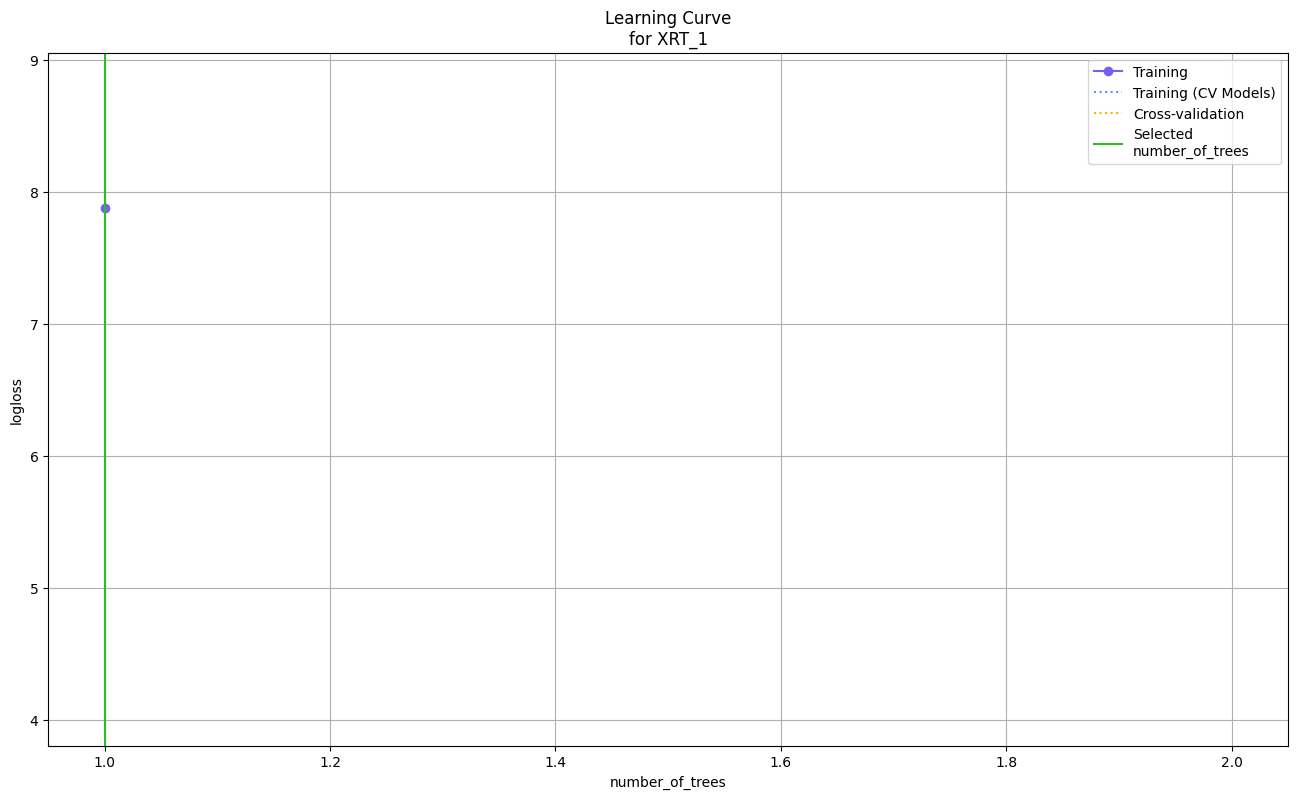

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

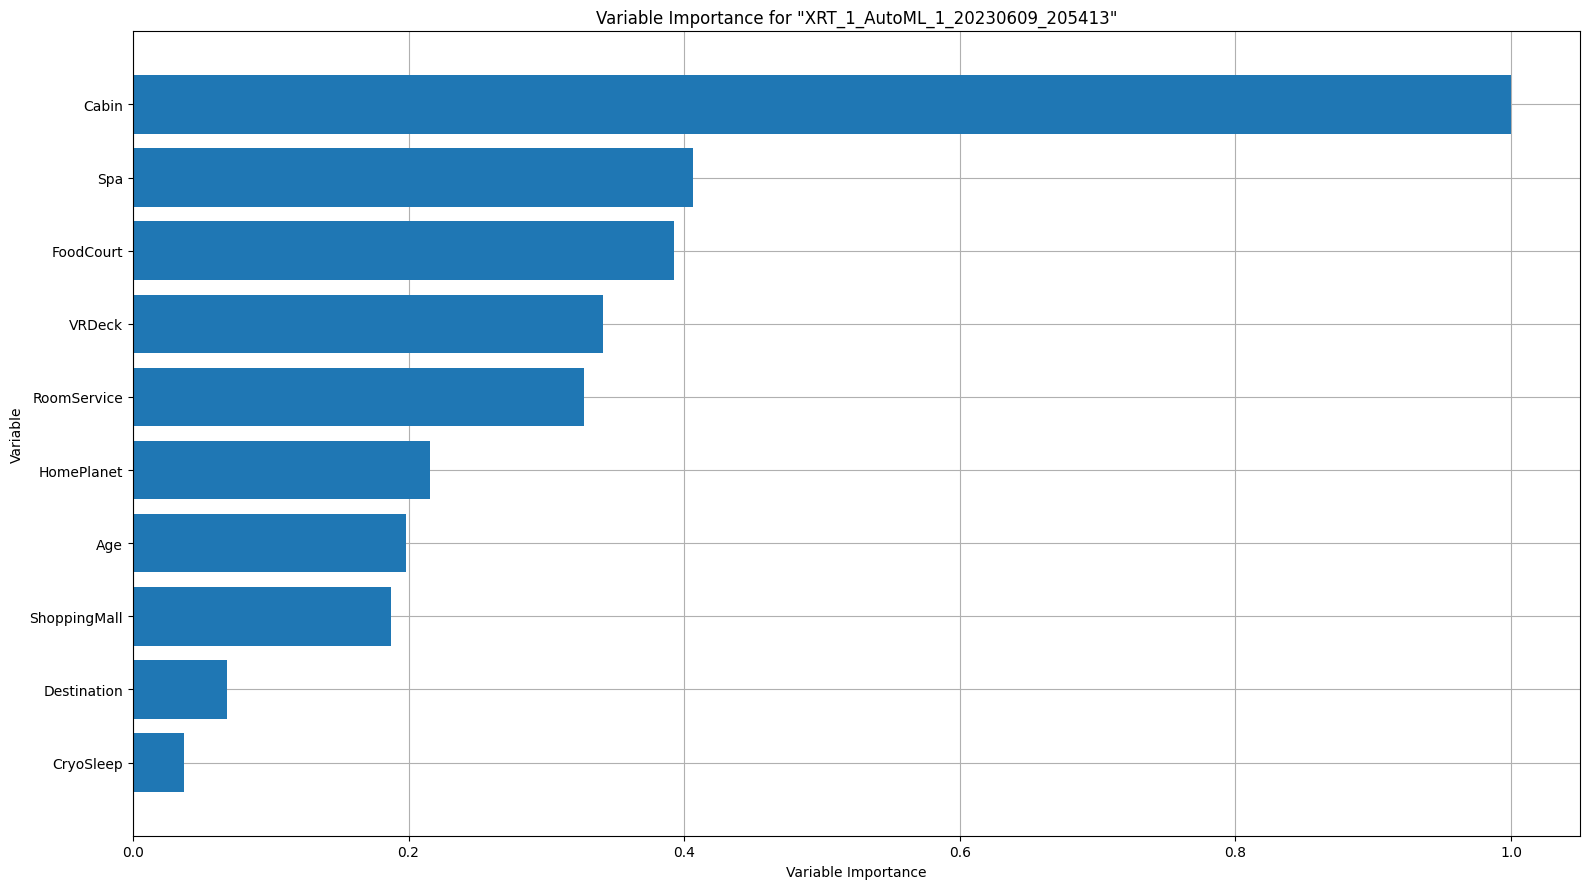

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

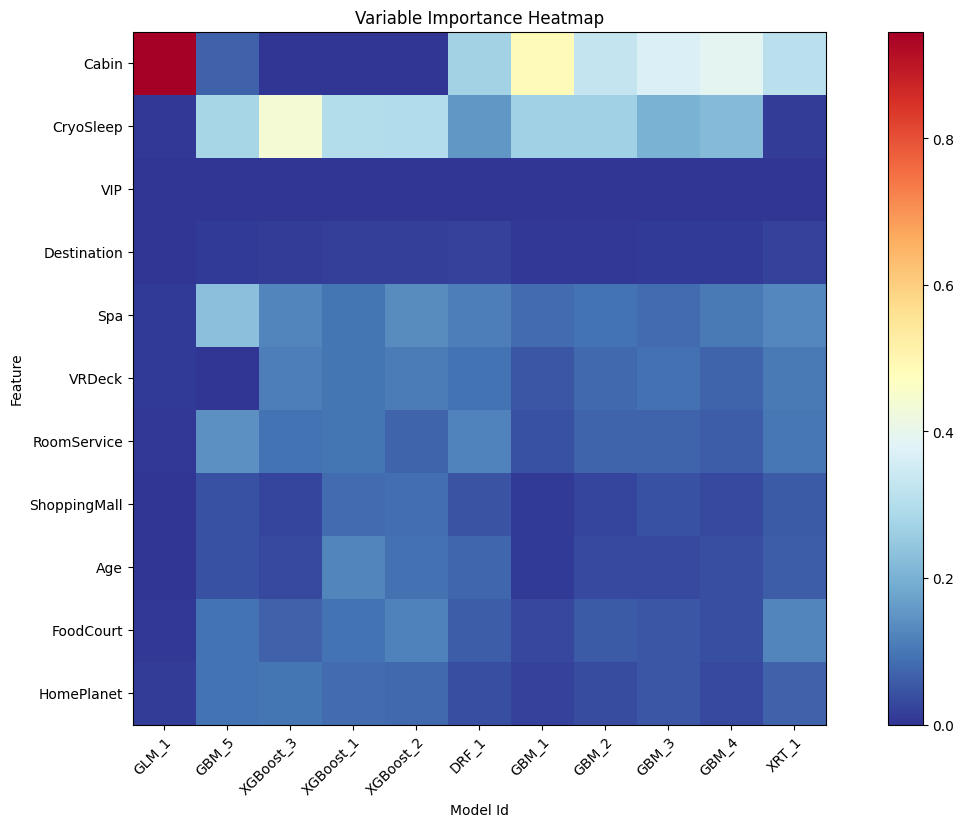

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

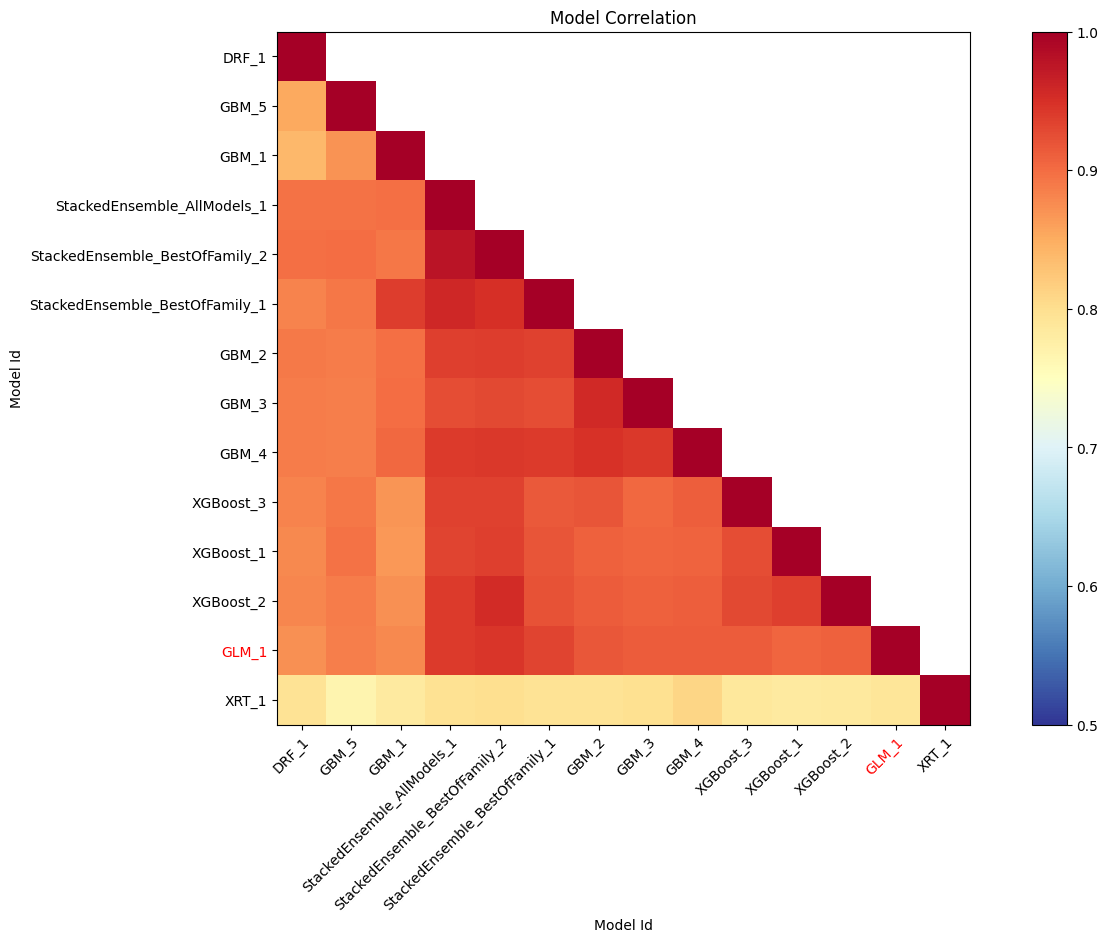

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

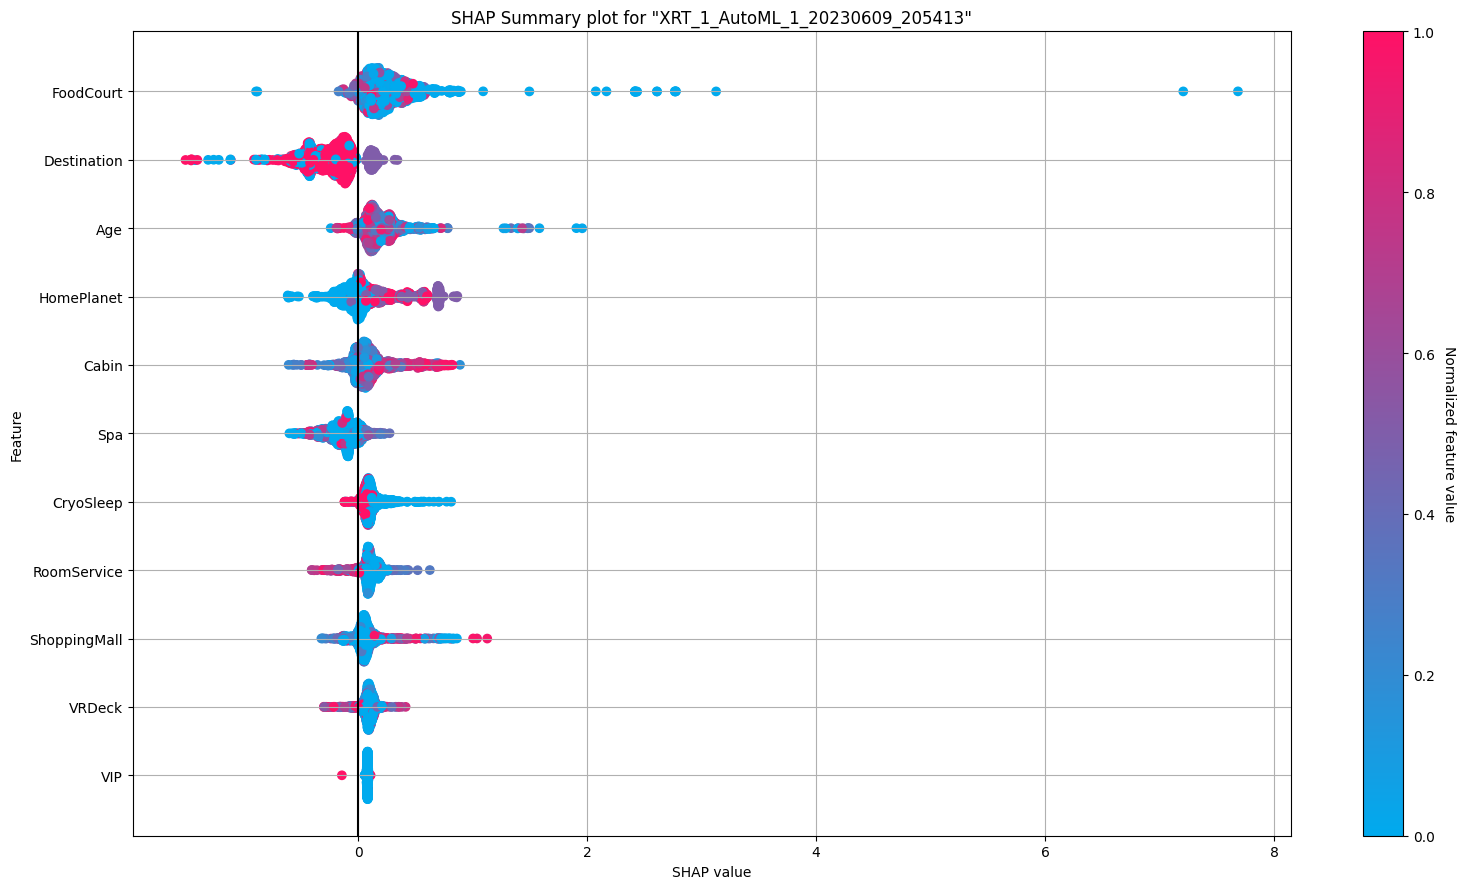

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

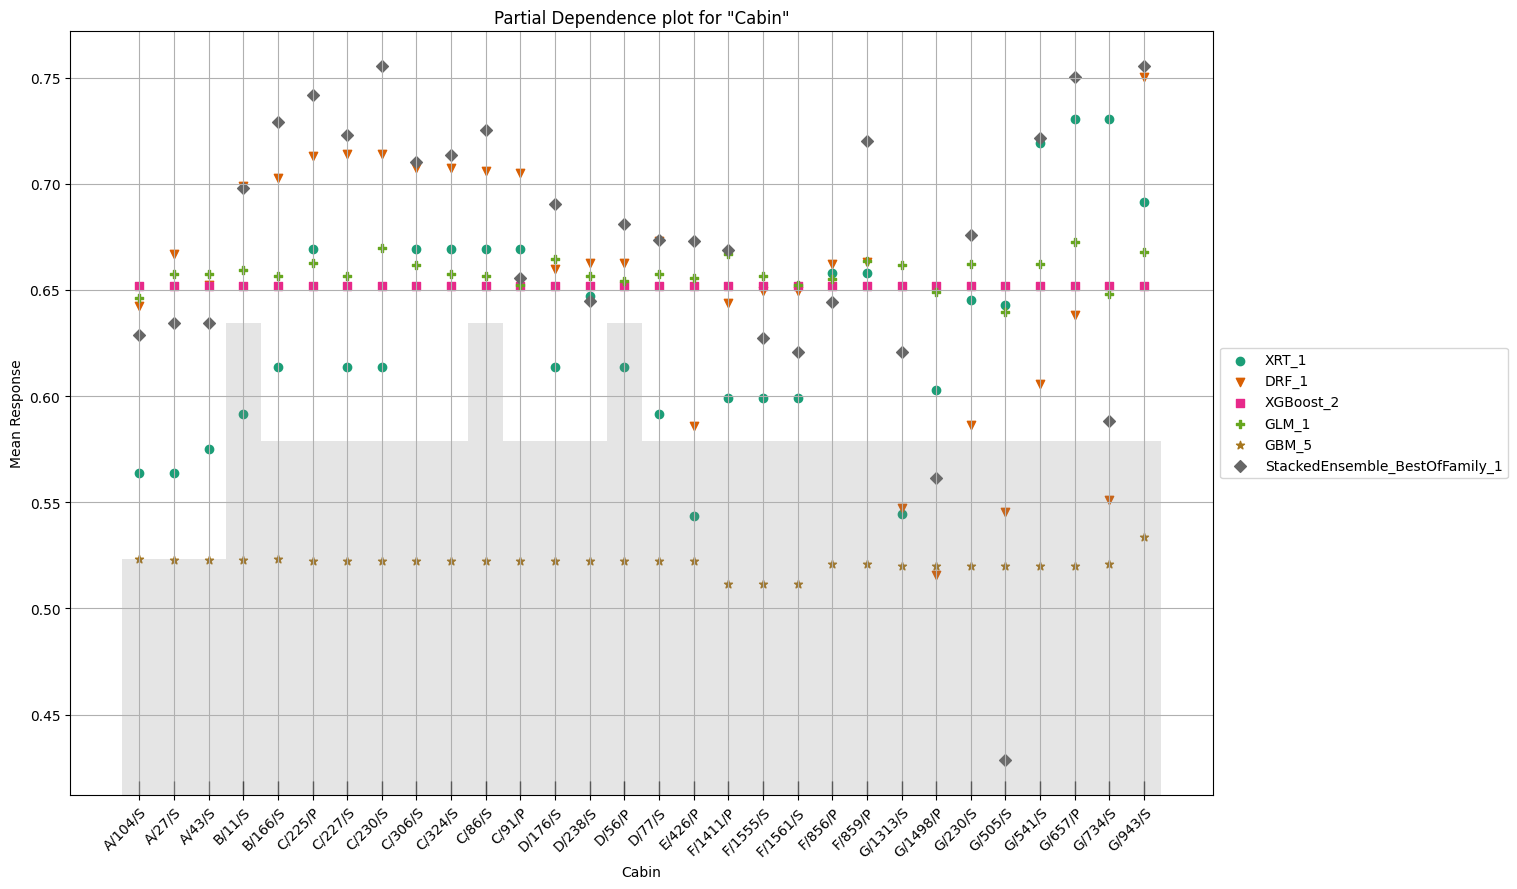

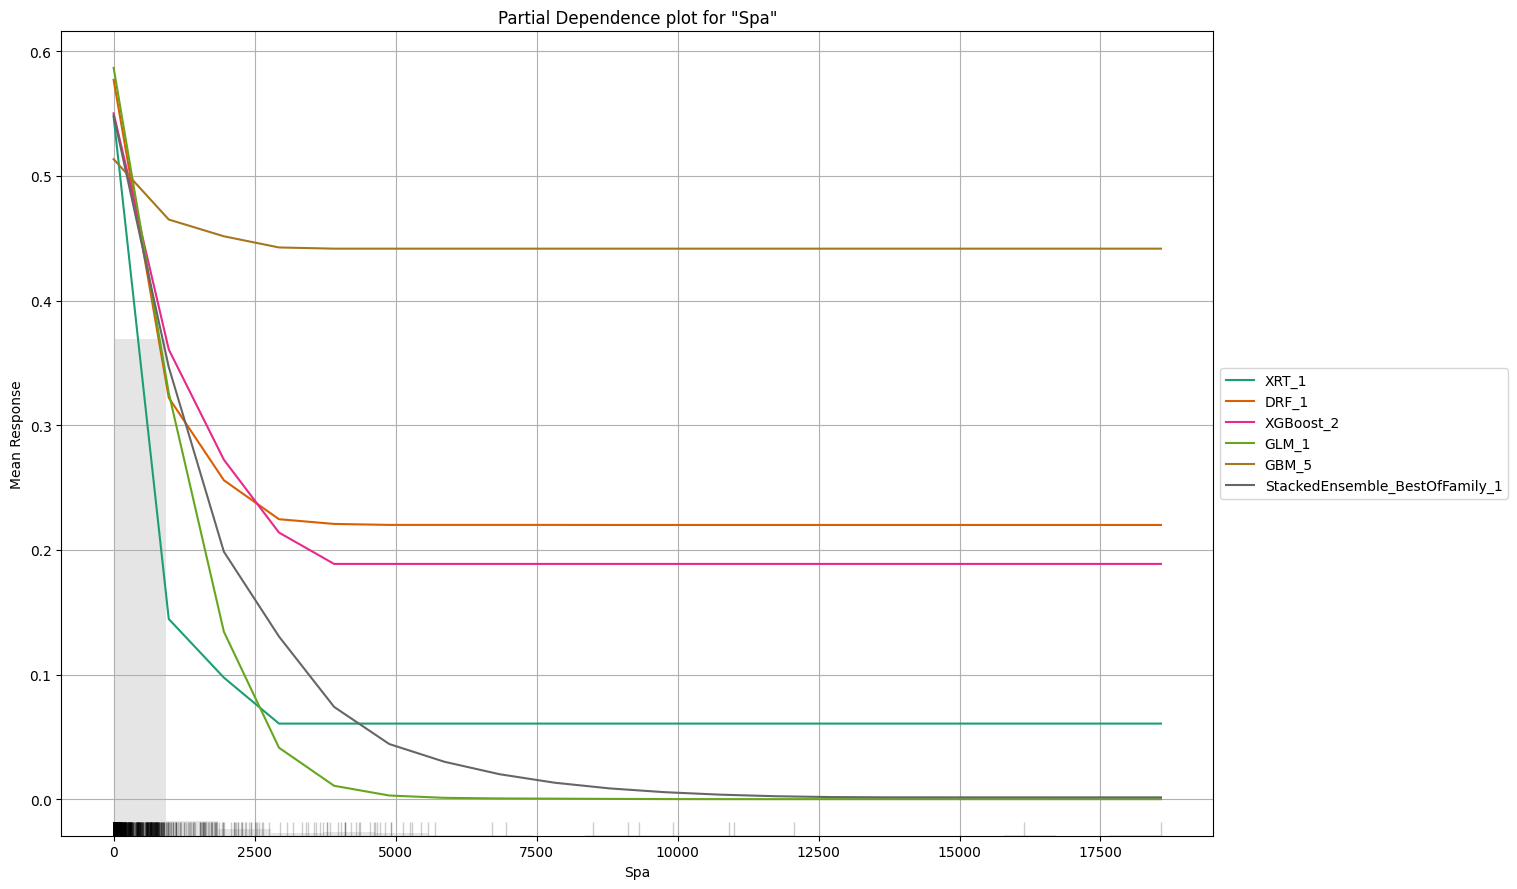

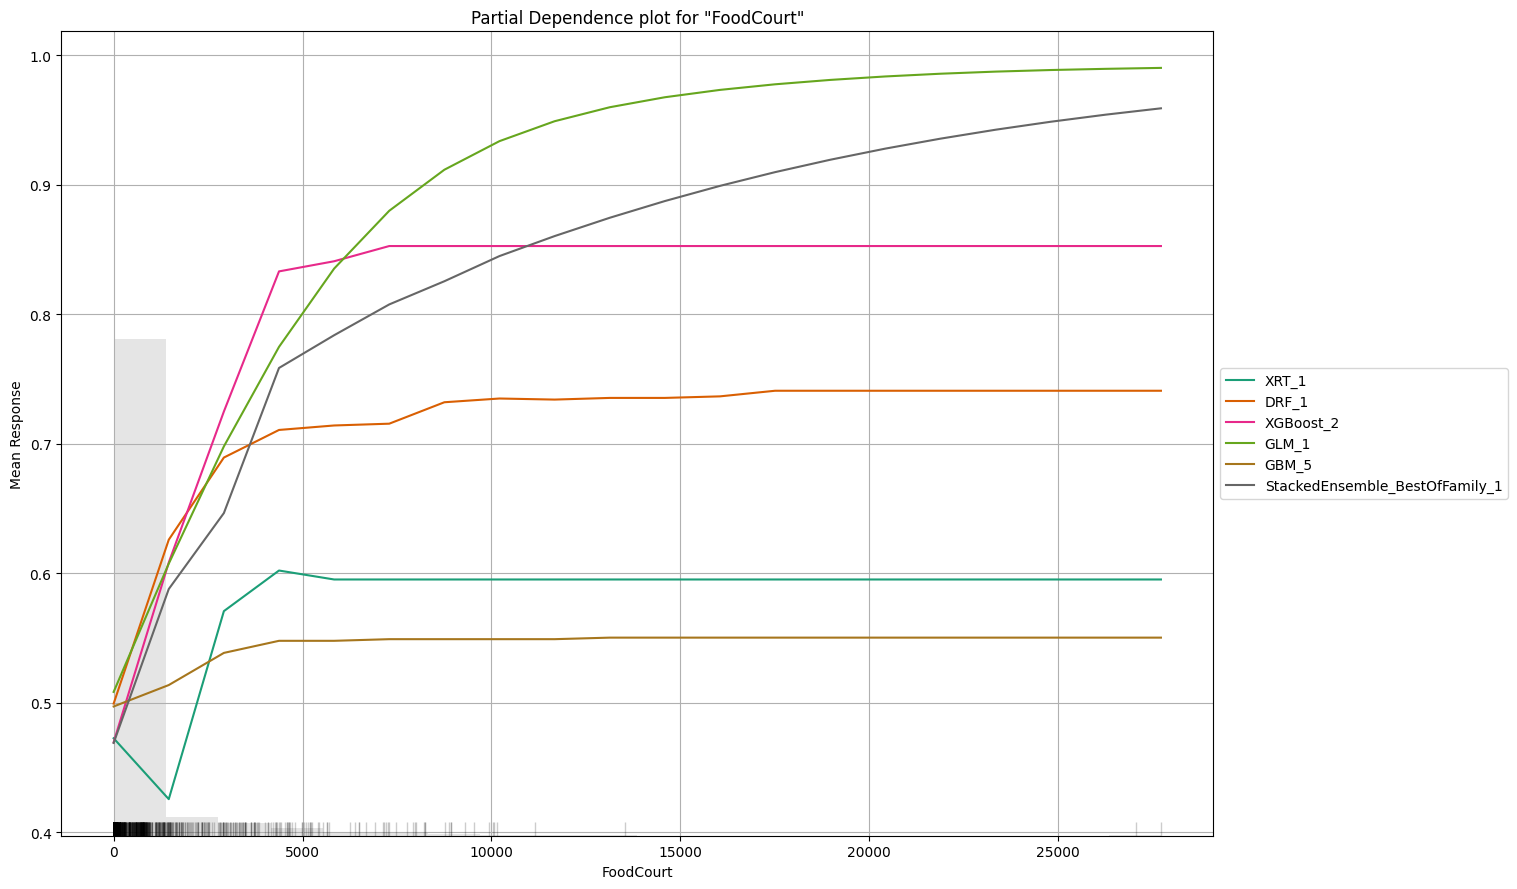

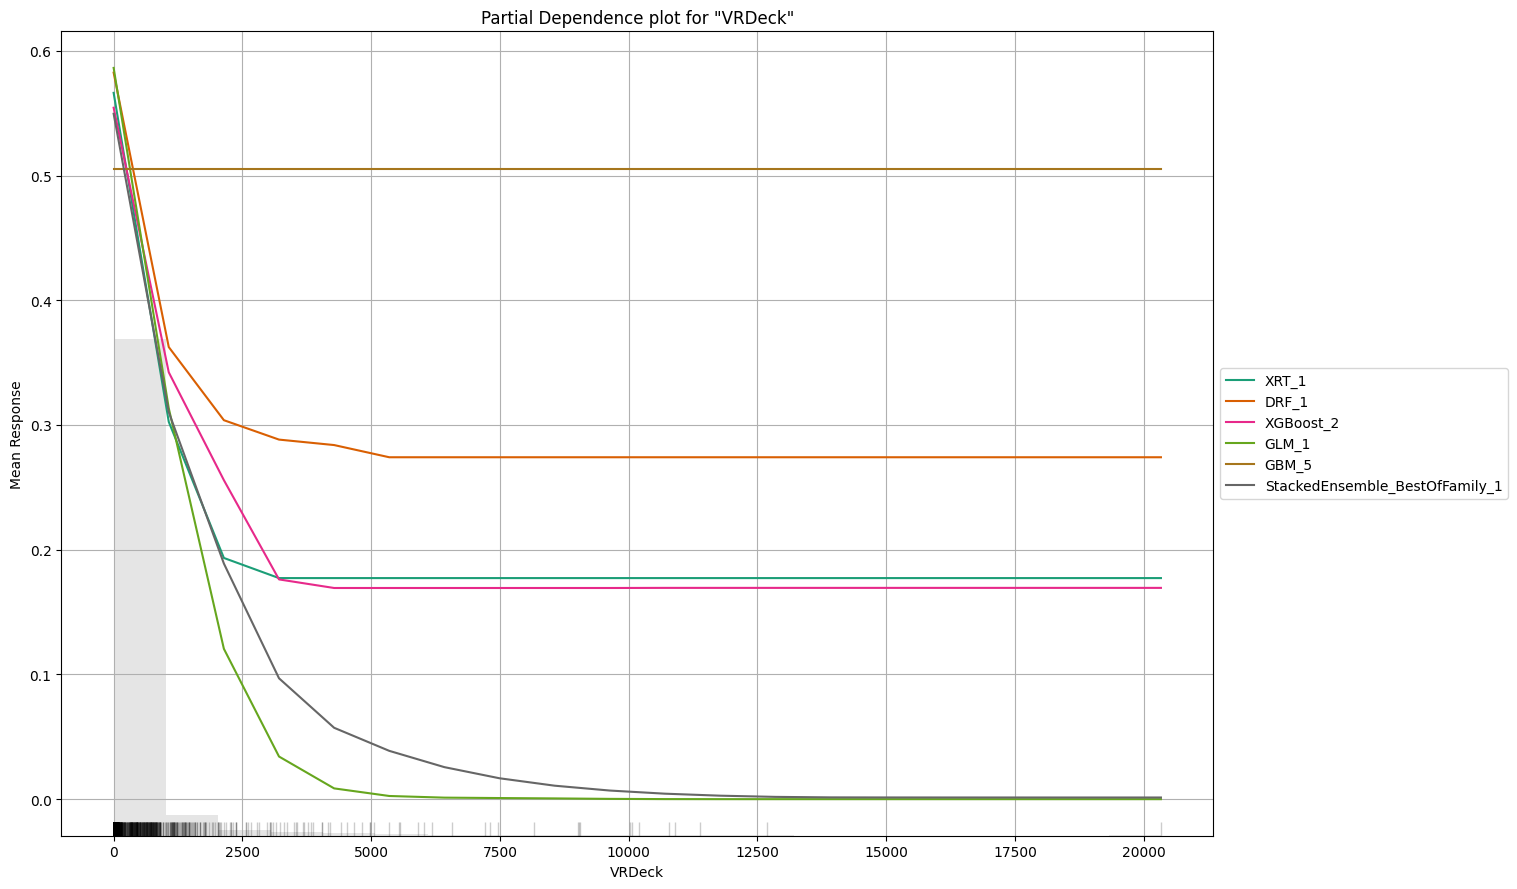

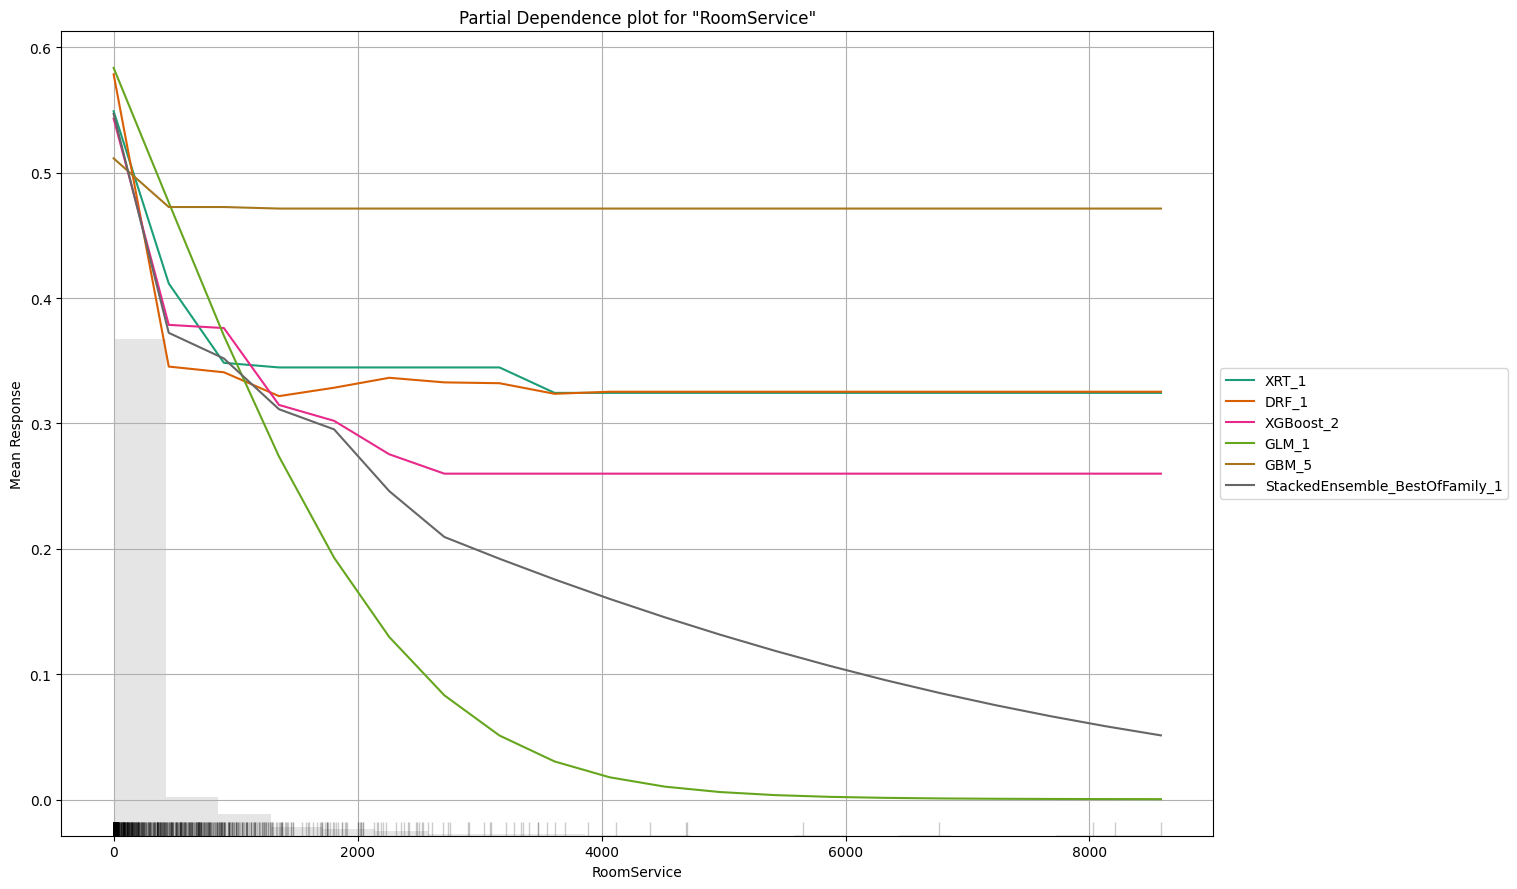

In [10]:
aml.explain(test);

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo             predict       False       True
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------  ---------  --------  ---------
StackedEnsemble_BestOfFamily_1_AutoML_1_20230531_170128  0.875048   0.442354  0.884473                0.214216  0.38023   0.144575                2442                   0.0932    StackedEnsemble  False      0.944854  0.0551456
StackedEnsemble_BestOfFamily_2_AutoML_1_20230531_170128  0.87454    0.440616  0.884127                0.215138  0.379829  0.14427                 3369                   0.192618  StackedEnsemble  False      0.918842  0.0811578
StackedEnsemble_AllModels_1_AutoML_1_20230531_170128     0.874112   0.439684  0.884263                0.209878  0.379726  0.144192                3064                   0.124859  StackedEnsemble  False      0.911181  0.0888187
GBM_1_AutoML_1_20230531_170128                           0.866908   0.457988  0.872654                0.220034  0.386076  0.149054                6166                   0.117774  GBM              False      0.927223  0.0727766
GBM_3_AutoML_1_20230531_170128                           0.865887   0.466497  0.87317                 0.211232  0.388182  0.150685                 957                   0.069012  GBM              False      0.850698  0.149302
GBM_2_AutoML_1_20230531_170128                           0.861747   0.497959  0.871848                0.217242  0.400931  0.160746                1076                   0.036839  GBM              False      0.749491  0.250509
XGBoost_2_AutoML_1_20230531_170128                       0.860017   0.466194  0.870124                0.228467  0.390621  0.152585                 795                   0.016142  XGBoost          False      0.961632  0.0383681
XGBoost_1_AutoML_1_20230531_170128                       0.859587   0.471545  0.871617                0.221802  0.392043  0.153698                2165                   0.030258  XGBoost          False      0.989008  0.0109916
GBM_4_AutoML_1_20230531_170128                           0.85765    0.503454  0.865728                0.208447  0.403083  0.162476                1063                   0.05252   GBM              False      0.737336  0.262664
GLM_1_AutoML_1_20230531_170128                           0.855296   0.474503  0.864919                0.232575  0.396854  0.157493                1247                   0.023803  GLM              False      0.698195  0.301805
[12 rows x 13 columns]

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

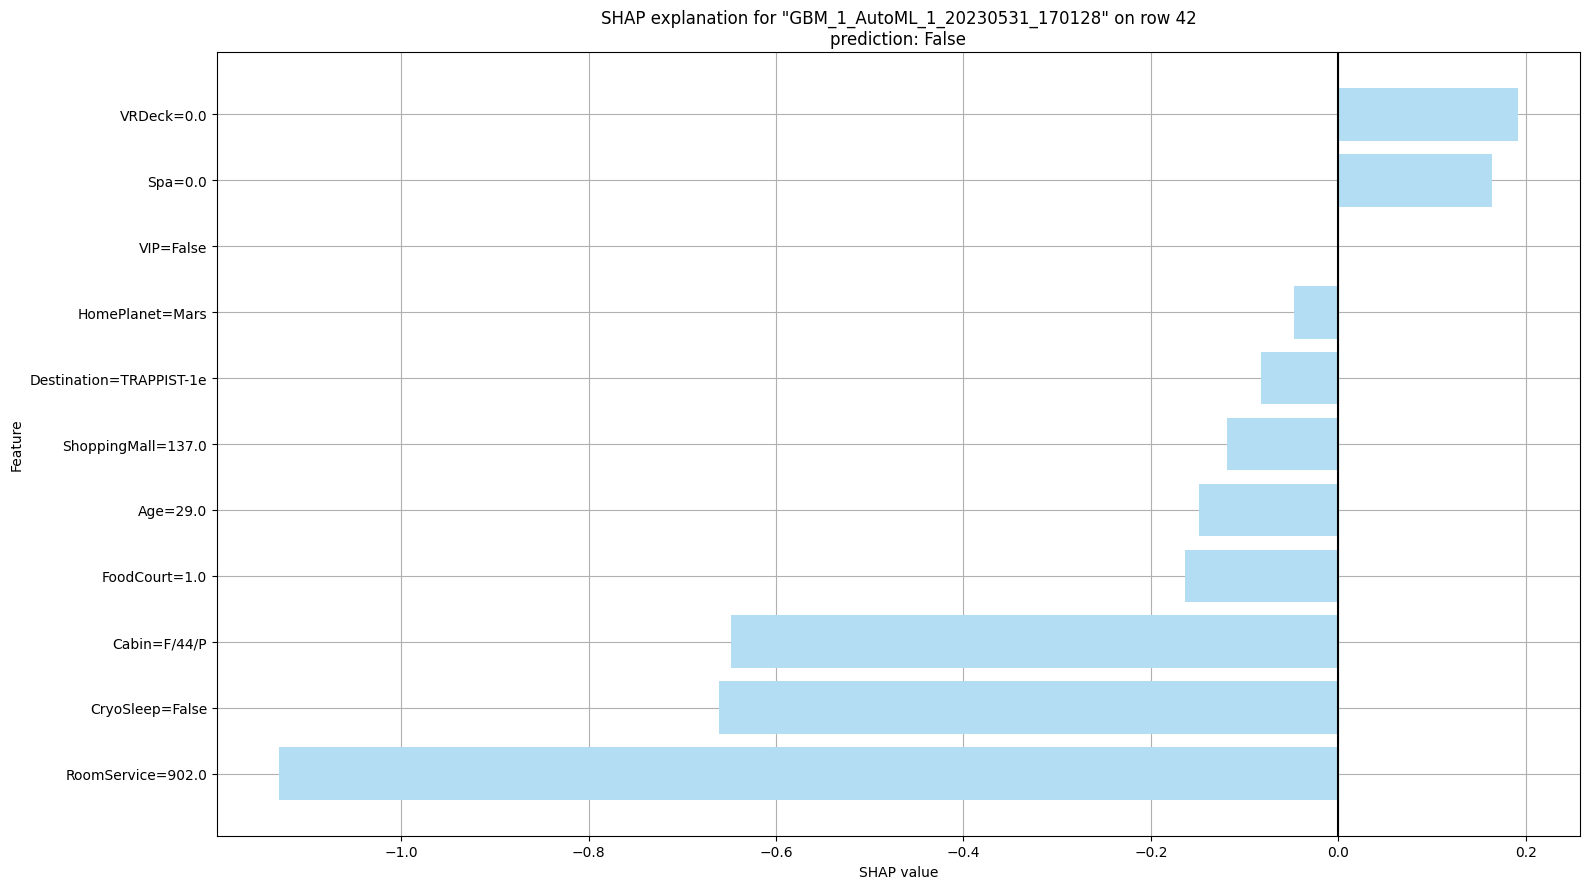

In [ ]:
aml.explain_row(test, row_index=42);